In [1]:
from google.colab import files
uploaded = files.upload()

Saving data_to_be_cleansed.csv to data_to_be_cleansed.csv


In [3]:
# Essential Libraries
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Download nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Define the text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        text = ''
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Load and process the data
data = pd.read_csv('/content/data_to_be_cleansed.csv')
data['clean_text'] = data['text'].apply(clean_text)

# Vectorize the text
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['clean_text']).toarray()

# Set up labels
y = data['target']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the vectorizer for later use in inference
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)


In [5]:
# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(5000,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(set(y)), activation='softmax')  # Set output layer for the number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Save the trained model
model.save("ann_model.keras")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2618 - loss: 1.5940 - val_accuracy: 0.5467 - val_loss: 1.3789
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5690 - loss: 1.2173 - val_accuracy: 0.6684 - val_loss: 0.9228
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7712 - loss: 0.7123 - val_accuracy: 0.7125 - val_loss: 0.8013
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8551 - loss: 0.4704 - val_accuracy: 0.7219 - val_loss: 0.7964
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9058 - loss: 0.3217 - val_accuracy: 0.7135 - val_loss: 0.8142
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9169 - loss: 0.2543 - val_accuracy: 0.7261 - val_loss: 0.8718
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9368 - loss: 0.2075 - val_accuracy: 0.7051 - val_loss: 0.9128
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9410 - loss: 0.1814 - val_accu

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


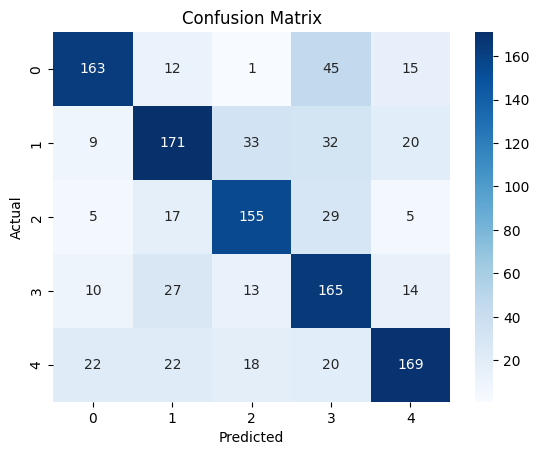

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       236
           1       0.69      0.65      0.67       265
           2       0.70      0.73      0.72       211
           3       0.57      0.72      0.63       229
           4       0.76      0.67      0.71       251

    accuracy                           0.69      1192
   macro avg       0.70      0.69      0.69      1192
weighted avg       0.70      0.69      0.69      1192



In [6]:
# Predict the test set results
y_pred = model.predict(X_test).argmax(axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


In [12]:
import re
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the saved model and vectorizer
model = load_model("ann_model.keras")
with open("tfidf_vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

# Define the text cleaning function (same as used during training)
def clean_text(text):
    if not isinstance(text, str):
        text = ''
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Sample data for testing
new_data = ["I'm tensed for the exam.", "Life is beautiful and I am very happy!"]

# Clean and transform the new data
new_data_cleaned = [clean_text(text) for text in new_data]
X_new = vectorizer.transform(new_data_cleaned).toarray()

# Make predictions
predictions = model.predict(X_new).argmax(axis=1)

# Define label mapping based on provided information
label_mapping = {
    0: "Stress",
    1: "Depression",
    2: "Bipolar disorder",
    3: "Personality disorder",
    4: "Anxiety"
}

# Convert predictions to readable labels
readable_predictions = [label_mapping[pred] for pred in predictions]
print("Predictions (readable):", readable_predictions)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Predictions (readable): ['Stress', 'Bipolar disorder']
